In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import warnings
from sklearn.preprocessing import OneHotEncoder
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
n_splits = 5
seed = 35
path = 'E:/BDCI Match/'

#文件路径
traindataFile = path + 'train.csv'
testdataFile = path+ 'test.csv'
train_supdataFile = path + 'train2/test.csv'
train_supdataFileLabel = path + 'train2/standard.csv'

#补充训练集处理
train_sup = pd.read_csv(train_supdataFile)
train_supLabel = pd.read_csv(train_supdataFileLabel)

train_sup = pd.merge(train_sup,train_supLabel,on = 'user_id')


#文件加载
train = pd.read_csv(traindataFile)
test = pd.read_csv(testdataFile)

#合并训练集
train = train.append(train_sup,ignore_index = True)
train

#current_service为99104722的记录可以剔除，因为service_type=3 <=> current_service=99104722
train1 = train.loc[train['service_type']==1]
train1 = train1.reset_index()

train2 = train.loc[train['service_type']==4]
train2 = train2.reset_index()

test1 = test.loc[test['service_type']==1]
test1 = test1.reset_index()
test2 = test.loc[test['service_type']==4]
test2 = test2.reset_index()
test3 = test.loc[test['service_type']==3]
test3 = test3.reset_index()
test_id3 = test3['user_id']

# 对标签编码 映射关系
label2current_service1 = dict(zip(range(0,len(set(train1['current_service']))),sorted(list(set(train1['current_service'])))))
current_service2label1 = dict(zip(sorted(list(set(train1['current_service']))),range(0,len(set(train1['current_service'])))))

label2current_service2 = dict(zip(range(0,len(set(train2['current_service']))),sorted(list(set(train2['current_service'])))))
current_service2label2 = dict(zip(sorted(list(set(train2['current_service']))),range(0,len(set(train2['current_service'])))))

# 原始数据的标签映射
train1['current_service'] = train1['current_service'].map(current_service2label1)
train2['current_service'] = train2['current_service'].map(current_service2label2)

train1.pop("user_id")
train2.pop("user_id")

train1.pop("index")
train2.pop("index")

cols = train1.columns[train1.dtypes.eq('object')]
train1[cols] = train1[cols].apply(pd.to_numeric, errors='coerce')

cols = train2.columns[train2.dtypes.eq('object')]
train2[cols] = train2[cols].apply(pd.to_numeric, errors='coerce')

train1 = train1.dropna()
train2 = train2.dropna()

# train_col = train1.columns

# # 数据有问题数据
# for i in train_col:
#     train1[i] = train1[i].replace("\\N",-1)
#     train2[i] = train2[i].replace("\\N",-1)

,1_total_fee,2_total_fee,3_total_fee,4_total_fee,age,complaint_level,contract_time,contract_type,current_service,former_complaint_fee,...,many_over_bill,month_traffic,net_service,online_time,pay_num,pay_times,service1_caller_time,service2_caller_time,service_type,user_id
0,295.96,296.2,296,296.80,31,0,36,1,99999825,0.0,...,0,3813.614698,4,85,300.04,2,0.000000,564.366667,4,Gx4sJzcQog01UhZL
1,265.20,261.2,208.5,174.50,30,0,0,0,90063345,0.0,...,1,0.000000,4,10,300.00,3,355.166667,0.000000,1,kEXrhTiug93DIcLG
2,44.50,70.2,69,61.40,25,0,0,0,90109916,0.0,...,0,2598.397406,4,12,50.00,4,0.000000,98.416667,1,AouXr0EOUtSRdiYK
3,87.95,81.4,76,88.30,44,0,0,0,89950166,0.0,...,0,988.440563,4,134,100.00,1,74.483333,121.833333,4,Yds7U30hnRZDiLtb
4,317.04,314.08,435.51,413.05,31,2,24,1,99999825,0.0,...,0,5885.800642,4,84,1000.03,12,35.100000,496.733333,4,OFDTSXrhN9Q2mbVw
5,36.00,36,36,37.20,42,0,12,3,89950168,0.0,...,0,218.003452,4,46,30.00,1,0.000000,14.633333,4,4qHSn3dkPzJTAjoG
6,33.60,32.7,38.7,45.70,27,0,0,0,90063345,0.0,...,0,0.000000,4,12,50.00,1,136.033333,0.000000,1,tXkjbzpTsZcxYPKG
7,200.13,66.5,66.5,66.50,24,0,0,0,99104722,0.0,...,0,0.000000,4,68,300.00,4,0.000000,0.014444,3,Ip5i0LvzTkxyr1mQ
8,116.00,116,116,116.00,40,0,12,9,89950167,0.0,...,0,635.946276,4,109,200.00,2,0.000000,310.733333,4,ro43b68MustgPyOR
9,16.00,19.45,19.6,17.80,50,0,0,0,89016252,0.0,...,0,0.002190,2,29,90.00,3,0.000000,33.950000,4,PuslOvjEmUnqf2Fb


In [15]:
train.describe()

,1_total_fee,4_total_fee,complaint_level,contract_time,contract_type,current_service,former_complaint_fee,former_complaint_num,is_mix_service,is_promise_low_consume,...,local_trafffic_month,many_over_bill,month_traffic,net_service,online_time,pay_num,pay_times,service1_caller_time,service2_caller_time,service_type
count,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000,8.752170e+05,8.752170e+05,875217.000000,875217.000000,875217.000000,...,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000,875217.000000
mean,97.369308,102.846923,0.119289,6.663314,1.492100,9.225128e+07,3.500588e+06,0.139261,0.035886,0.067020,...,5823.213411,0.426620,1161.740209,3.906728,42.838560,115.796628,1.909785,42.388159,84.353695,2.749966
std,89.244336,101.014912,0.381304,9.928265,2.966979,4.217024e+06,2.341520e+09,0.490243,0.186006,0.250057,...,11279.025541,0.494586,2781.822384,0.394562,45.347794,208.239996,1.506331,110.142597,136.484418,1.438299
min,0.000000,-420.270000,0.000000,-1.000000,0.000000,8.901625e+07,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,0.010000,1.000000,0.000000,0.000000,1.000000
25%,46.200000,45.000000,0.000000,0.000000,0.000000,8.995017e+07,0.000000e+00,0.000000,0.000000,0.000000,...,94.976177,0.000000,0.000000,4.000000,10.000000,40.000000,1.000000,0.000000,0.000000,1.000000
50%,72.600000,74.100000,0.000000,0.000000,0.000000,9.006334e+07,0.000000e+00,0.000000,0.000000,0.000000,...,1262.570313,0.000000,139.218380,4.000000,21.000000,80.000000,1.000000,0.000000,29.116667,4.000000
75%,116.020000,129.250000,0.000000,12.000000,1.000000,9.015595e+07,0.000000e+00,0.000000,0.000000,0.000000,...,5178.791016,1.000000,1311.442349,4.000000,64.000000,120.000000,2.000000,34.350000,123.800000,4.000000
max,5940.830000,5141.270000,3.000000,52.000000,12.000000,9.999983e+07,1.762170e+12,37.000000,1.000000,1.000000,...,484365.746300,1.000000,159057.397800,9.000000,274.000000,58800.300000,127.000000,5139.483333,16454.383330,4.000000


In [5]:
train1.columns

Index(['service_type', 'is_mix_service', 'online_time', '1_total_fee',
       '2_total_fee', '3_total_fee', '4_total_fee', 'month_traffic',
       'many_over_bill', 'contract_type', 'contract_time',
       'is_promise_low_consume', 'net_service', 'pay_times', 'pay_num',
       'last_month_traffic', 'local_trafffic_month', 'local_caller_time',
       'service1_caller_time', 'service2_caller_time', 'gender', 'age',
       'complaint_level', 'former_complaint_num', 'former_complaint_fee',
       'current_service'],
      dtype='object')

In [11]:
X = np.array(train1[['service_type', 'is_mix_service', 'online_time', '1_total_fee',
       '2_total_fee', '3_total_fee', '4_total_fee', 'month_traffic',
       'many_over_bill', 'contract_type', 'contract_time',
       'is_promise_low_consume', 'net_service', 'pay_times', 'pay_num',
       'last_month_traffic', 'local_trafffic_month', 'local_caller_time',
       'service1_caller_time', 'service2_caller_time', 'gender', 'age',
       'complaint_level', 'former_complaint_num', 'former_complaint_fee']])
X.shape

(243407, 25)

In [12]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [13]:
X_std

array([[ 0.        , -0.02067488, -0.09819373, ..., -0.20220897,
        -0.18781162, -0.00202693],
       [ 0.        , -0.02067488,  0.1568432 , ..., -0.20220897,
        -0.18781162, -0.00202693],
       [ 0.        , -0.02067488,  0.1568432 , ..., -0.20220897,
        -0.18781162, -0.00202693],
       ...,
       [ 0.        , -0.02067488, -0.6082676 , ..., -0.20220897,
        -0.18781162, -0.00202693],
       [ 0.        , -0.02067488, -0.86330454, ..., -0.20220897,
        -0.18781162, -0.00202693],
       [ 0.        , -0.02067488,  0.41188014, ..., -0.20220897,
        -0.18781162, -0.00202693]])

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#创建PCA对象，n_components=3
pca = PCA(n_components=2)

#使用PCA对特征进行降维
X_std_pca = pca.fit_transform(X_std)

labels_true

kmeans = KMeans(n_clusters=3,random_state=0).fit(X_std_pca)

In [15]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2,init='pca',random_state=0)
X_tsne = tsne.fit_transform(X_std) 

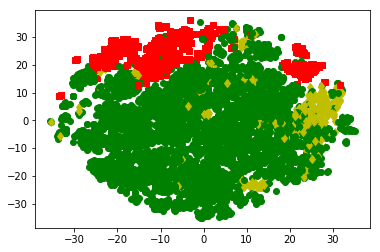

In [33]:
labels_true = train1['current_service']

colors = ['g','r','y','b']
markers = ['o','s','d','h']
for i,l in enumerate(labels_true):
    plt.plot(X_tsne[i][0],X_tsne[i][1],color=colors[l],marker=markers[l],ls='None')
    if i > 5000:
        break

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,random_state=0).fit(X_tsne)

Text(0.5,1,'243407 Countries K-Means')

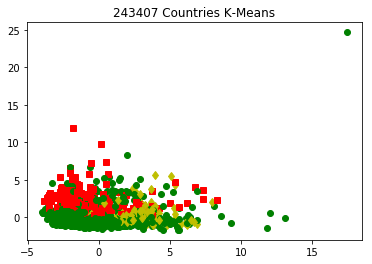

In [30]:
labels = kmeans.labels_
labels_true = train1['current_service']

colors = ['g','r','y','b']
markers = ['o','s','d','h']
for i,l in enumerate(labels_true):
    plt.plot(X_std_pca[i][0],X_std_pca[i][1],color=colors[l],marker=markers[l],ls='None')
    if i > 2000:
        break
plt.title('%s Countries K-Means'%(len(X_std_pca)))

Text(0.5,1,'243407 Countries K-Means')

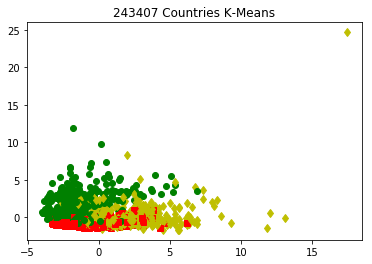

In [31]:
labels = kmeans.labels_
labels_true = train1['current_service']

colors = ['g','r','y','b']
markers = ['o','s','d','h']
for i,l in enumerate(labels):
    plt.plot(X_std_pca[i][0],X_std_pca[i][1],color=colors[l],marker=markers[l],ls='None')
    if i > 2000:
        break
plt.title('%s Countries K-Means'%(len(X_std_pca)))

Text(0.5,1,'243407 Countries K-Means')

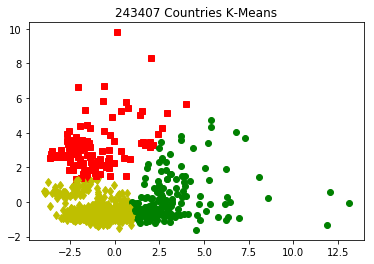

In [8]:
labels = kmeans.labels_
labels_true = train1['current_service']

colors = ['g','r','y','b']
markers = ['o','s','d','h']
for i,l in enumerate(labels):
    plt.plot(X_std_pca[i][0],X_std_pca[i][1],color=colors[l],marker=markers[l],ls='None')
    if i > 1000:
        break
plt.title('%s Countries K-Means'%(len(X_std_pca)))

Text(0.5,1,'243407 Countries K-Means')

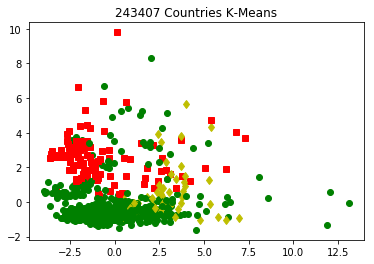

In [9]:
labels = kmeans.labels_
labels_true = train1['current_service']

colors = ['g','r','y','b']
markers = ['o','s','d','h']
for i,l in enumerate(labels_true):
    plt.plot(X_std_pca[i][0],X_std_pca[i][1],color=colors[l],marker=markers[l],ls='None')
    if i > 1000:
        break
plt.title('%s Countries K-Means'%(len(X_std_pca)))

In [16]:
labels = tsne.embedding_
labels_true = train1['current_service']

colors = ['g','r','y','b']
markers = ['o','s','d','h']
for i,l in enumerate(labels):
    plt.plot(X_std_pca[i][0],X_std_pca[i][1],color=colors[l],marker=markers[l],ls='None')
    if i > 1000:
        break
plt.title('%s Countries K-Means'%(len(X_std_pca)))

TypeError: only integer scalar arrays can be converted to a scalar index

In [24]:
X_tsne

array([[ 21.356644,  10.677128],
       [-23.867043,  19.516138],
       [-16.12014 ,  13.990689],
       ...,
       [-23.251799, -18.75564 ],
       [ 17.250614, -25.721598],
       [-12.143326,  -5.596643]], dtype=float32)